## LAB ØVELSE: Sentiment analyse i Python

### Om øvelsen

I denne øvelse skal I anvende sentiment analyse på sætninger i refereater fra Folketinget. I opfordres til at bruge `asent` til at undersøge sentiment, men hvordan I inddeler tekststykkerne og udleder dem, er op til jer.

Som sædvanligt med disse "lab øvelser" er der ikke én bestemt måde at gøre tingene på, så overvej selv, hvilken fremgangsmåde, som er mest hensigtsmæssig og som giver mest mening for jer.


**Formål**

Vi vil gerne undersøge udviklingen i, hvordan man omtaler "EU" i Folketinget. 

### Om datasættet

Datasættet består af referater fra møder i Folketingssalen fra 2008-2022. Data er scrapet fra [https://www.ft.dk/da/dokumenter/dokumentlister/referater](https://www.ft.dk/da/dokumenter/dokumentlister/referater) i december 2022. 

I finder datasæt i mappen "data/dk_parl". Der findes to version:

- `dkparl_parsed_20221216.json`: Rådata der indeholder al information, som kan udledes af mødereferaters HTML.
- `dkparl_simple_20221216.json`: Simplificeret udgave, der blot indeholder dato for mødetidspunkt og tekststykker for hvert dagsordenspunkt (uden titel).

*Det anbefales, at I bruger `dkparl_simple_20221216.json`*.

**Datasættets struktur**

`dkparl_simple_20221216.json` er en JSON-fil i "records"-format. Hver linje i data er et møde i Folketingssalen. Hver linje indeholder dato for mødet samt liste af referater af de enkelte punkter (som strings):

```
{'DateOfSitting': dato,
 'items': [tekst1, tekst2, ..., tekstN]}
{'DateOfSitting': dato,
 'items': [tekst1, tekst2, ..., tekstN]}
{'DateOfSitting': dato,
 'items': [tekst1, tekst2, ..., tekstN]}
{'DateOfSitting': dato,
 'items': [tekst1, tekst2, ..., tekstN]}
```

**1.**

Indlæs datasættet i Python. Overvej hvilken datastruktur som datasættet passer ind i. (se evt. `json.load()` funktionen fra pakken `json`: https://docs.python.org/3.8/library/json.html#json.load eller brug pandas: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_json.html (`orient = 'records'`)).


**2.**

Overvej hvad data siger noget om. Hvad kan data bruges til i en samfundsanalytisk kontekst?


**3.**

Udled tekststykker (afsnit, sætninger eller andet), hvor EU italesættes (ud fra token, regex eller string matching).


**4.**

Anvend sentiment analyse på de udledte tekststykker. 

Det er altid en god ide at se, om man kan få funktionen til at virke på et enkelt tekststykke, før man skalerer op. 

Når sentiment analyse skal skaleres op (altså anvendes på flere tekststykker), kan det være en fordel at skrive en wrapper funktion (en funktion der tager et tekststykke som input og giver en samlet polaritetsscore som output).


**5.**

Undersøg udviklingen i sentiment ift. EU.

In [15]:
# indlæser pakker

import os
from os.path import join
import json
import pandas as pd
import spacy
from datetime import datetime
import re
from tqdm import tqdm
from plotnine import ggplot, aes, geom_smooth, scale_x_date, labs, theme, element_text

import spacy
import asent

# indlæs spacy sprogmodel og pipeline
nlp = spacy.load('da_core_news_md') # sprogmodel skal være hentet inden, at den kan indlæses

# tilføj sentiment model til pipeline
nlp.add_pipe('asent_da_v1')

In [2]:
file_p = join('/work', '83232', 'data', 'dk_parl', 'dkparl_simple_20221216.json') # sti til data
parldata = pd.read_json(file_p, orient = 'records') # indlæs med pandas

parldata = parldata.explode('items').reset_index(drop = True) # omdan lister af tekster til rækker - en række per tekst
parldata = parldata.dropna() # fjerner missing
parldata['date'] = pd.to_datetime(parldata['DateOfSitting']) # konverter datoformat
parldata['items'] = parldata['items'].astype(str) # tvinger til string

parldata.head()

,DateOfSitting,items,date
0,2008-11-04T13:00:00,\nMødet er åbnet.\nMedlemmer af Folketinget Pe...,2008-11-04 13:00:00
1,2008-11-04T13:00:00,1) 2. behandling af lovforslag nr. L 31:\nFors...,2008-11-04 13:00:00
2,2008-11-04T13:00:00,2) 2. behandling af lovforslag nr. L 37:\nFors...,2008-11-04 13:00:00
3,2008-11-04T13:00:00,3) 1. behandling af beslutningsforslag nr. B 1...,2008-11-04 13:00:00
4,2008-11-04T13:00:00,4) 1. behandling af beslutningsforslag nr. B 2...,2008-11-04 13:00:00


In [3]:
parldata.shape

(27106, 3)

In [4]:
# funktion til at udlede sætninger om EU - her som sætninger som indeholder "EU" adskilt med punktummer
# (bruger funktion og apply da pandas string metode gav fejl)

def eu_extract(text):
    regex_ruler = re.compile(r'(?<=\.)([^\.]*\bEU\b[^\.]*)(?=\.)', flags = re.MULTILINE | re.DOTALL)

    matches = regex_ruler.findall(text)

    return(matches)

# anvend funktion til at udlede sætninger
parldata['eu_matches'] = parldata['items'].apply(eu_extract)

In [5]:
# udvid data igen - en række per sætning og fjern missing.
eu_s = parldata.explode('eu_matches').dropna().reset_index(drop = True) 
eu_s.head()

,DateOfSitting,items,date,eu_matches
0,2008-11-04T13:00:00,3) 1. behandling af beslutningsforslag nr. B 1...,2008-11-04 13:00:00,Stabilitet på Balkan er en meget vigtig målsæ...
1,2008-11-04T13:00:00,3) 1. behandling af beslutningsforslag nr. B 1...,2008-11-04 13:00:00,Landets reformvillighed har taget en fornufti...
2,2010-04-14T13:00:00,Spm. nr. US 111\nNår man ser på den diskussion...,2010-04-14 13:00:00,"Det er nemlig helt åbenlyst, at vi er i en li..."
3,2014-02-06T10:00:00,2) 3. behandling af lovforslag nr. L 91:\nFors...,2014-02-06 10:00:00,(Henstand med exitskat ved selskabers overfør...
4,2014-02-06T10:00:00,9) 1. behandling af lovforslag nr. L 121:\nFor...,2014-02-06 10:00:00,(Implementering af EU’s energieffektivitetsdi...


In [6]:
# sentiment wrapper - blot en sum af samlet polarity (compound) for sætningerne.

def simple_asent(doc):

    compound_polarity = sum([sentence._.polarity.compound for sentence in doc.sents])

    return(compound_polarity)

In [7]:
# udled sentiment af sætningerne - samles i liste for at kunne bruge nlp.pipe (hurtigere bearbejdning af tekst)

sentiments = []

for doc in nlp.pipe(eu_s['eu_matches']): 
    sentiment = simple_asent(doc)

    sentiments.append(sentiment)

In [8]:
# tilføj til dataframe

eu_s['sentiment'] = pd.Series(sentiments)

In [9]:
eu_s.head()

,DateOfSitting,items,date,eu_matches,sentiment
0,2008-11-04T13:00:00,3) 1. behandling af beslutningsforslag nr. B 1...,2008-11-04 13:00:00,Stabilitet på Balkan er en meget vigtig målsæ...,0.187672
1,2008-11-04T13:00:00,3) 1. behandling af beslutningsforslag nr. B 1...,2008-11-04 13:00:00,Landets reformvillighed har taget en fornufti...,0.000000
2,2010-04-14T13:00:00,Spm. nr. US 111\nNår man ser på den diskussion...,2010-04-14 13:00:00,"Det er nemlig helt åbenlyst, at vi er i en li...",0.250000
3,2014-02-06T10:00:00,2) 3. behandling af lovforslag nr. L 91:\nFors...,2014-02-06 10:00:00,(Henstand med exitskat ved selskabers overfør...,0.458831
4,2014-02-06T10:00:00,9) 1. behandling af lovforslag nr. L 121:\nFor...,2014-02-06 10:00:00,(Implementering af EU’s energieffektivitetsdi...,0.000000


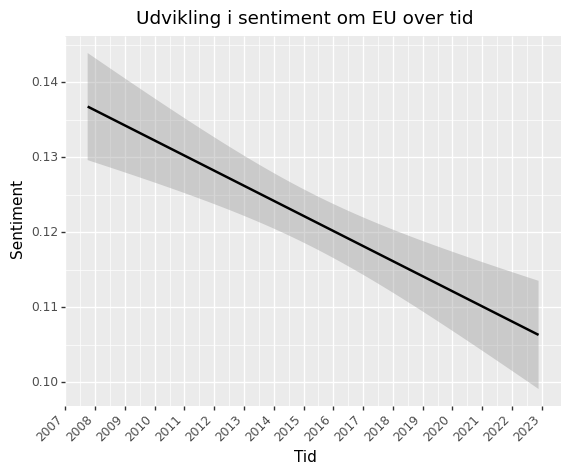

<ggplot: (8769129814781)>

In [16]:
# dan visualisering

(ggplot(data = eu_s, mapping = aes(x = 'date', y = 'sentiment')) + 
 geom_smooth(method = 'lm') + 
 scale_x_date(date_breaks = '1 year', date_labels = '%Y') + 
 labs(x = 'Tid', y = 'Sentiment', title = 'Udvikling i sentiment om EU over tid') + 
 theme(axis_text_x = element_text(angle=45, hjust=1)))